# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
!nvidia-smi

Sat Mar 27 10:54:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 6.4MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

print(tf.version.VERSION)

2.4.1


## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.preprocessing.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/Group/Flora/Private/Datasets/train'
validation_dir = '/content/drive/MyDrive/Group/Flora/Private/Datasets/valid'
checkpoint_dir = '/content/drive/MyDrive/Group/Flora/Private/Model/Checkpoint/Flora_EfficientNetB7/cp.ckpt'
checkpoint_FineTune_dir = '/content/drive/MyDrive/Group/Flora/Private/Model/Checkpoint/Flora_EfficientNetB7_FineTune/cp.ckpt'

BATCH_SIZE = 4
IMG_SIZE = (300, 300)

In [ ]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical')

Found 460 files belonging to 55 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  label_mode='categorical')

Found 348 files belonging to 55 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['Acacia confusa',
 'Albizia lebbek',
 'Araucaria heterophylla',
 'Averrhoa carambola',
 'Bauhinia blakeana',
 'Bauhinia purpurea',
 'Carica papaya',
 'Casuarina equisetifolia',
 'Citrus maxima',
 'Citrus reticulata',
 'Clausena lansium',
 'Cycas revoluta',
 'Dimocarpus longan',
 'Erythrina variegata',
 'Eucalyptus citriodora',
 'Ficus religiosa',
 'Ficus rumphii',
 'Firmiana simplex',
 'Gordonia axillaris',
 'Hyophorbe lagenicaulis',
 'Juniperus chinensis var_ kaizuka',
 'Litchi chinensis',
 'Macaranga tanarius',
 'Murraya paniculata',
 'Nerium oleander',
 'Osmanthus fragrans',
 'Pandanus tectorius',
 'Pinus massoniana',
 'Plumeria rubra var. acutifolia',
 'Podocarpus macrophyllus',
 'Psidium guajava',
 'Ravenala madagascariensis',
 'Rhus succedanea',
 'Salix babylonica',
 'Schefflera actinophylla',
 'Schefflera octophylla',
 'Thevetia peruviana',
 'Thuja orientalis',
 '假檳榔',
 '印度橡樹',
 '垂葉榕',
 '大葉榕',
 '大葉紫薇',
 '散尾葵',
 '日本葵',
 '棕櫚',
 '檜',
 '王棕',
 '白千層',
 '白蘭',
 '短穗魚尾葵',
 '細葉榕',
 '蒲葵',


As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

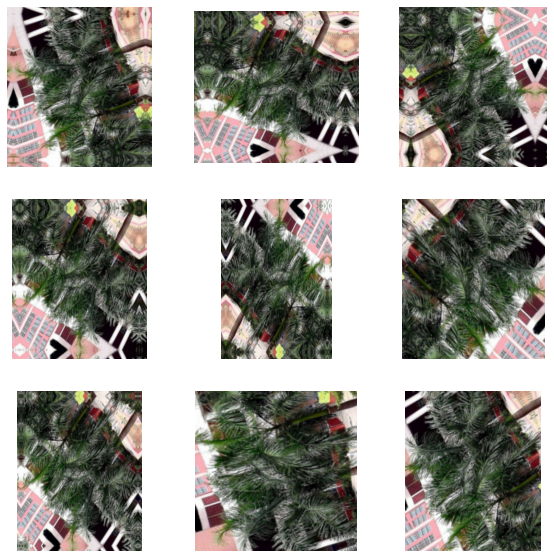

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
from efficientnet.tfkeras import preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
from efficientnet.tfkeras import EfficientNetB3

base_model = EfficientNetB3(input_shape=IMG_SIZE + (3,),
                            include_top=False,
                            weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnet-b3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_9[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 1536)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
x = tf.keras.layers.Flatten()(base_model.output)

In [ ]:
from glob import glob

In [ ]:
folders = glob('/content/drive/MyDrive/Group/Flora/Private/Datasets/train/*')

In [ ]:
prediction_layer = tf.keras.layers.Dense(len(folders), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 55)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_9 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
efficientnet-b3 (Functional) (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0   

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 30

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    steps_per_epoch=len(train_dataset),
                    validation_steps=len(validation_dataset),
                    callbacks=[cp_callback])

Epoch 1/30
115/115 [==============================] - 29s 170ms/step - loss: 4.2186 - accuracy: 0.0149 - val_loss: 4.0487 - val_accuracy: 0.0179
Epoch 2/30
115/115 [==============================] - 15s 125ms/step - loss: 3.9214 - accuracy: 0.0405 - val_loss: 4.0198 - val_accuracy: 0.0179
Epoch 3/30
115/115 [==============================] - 13s 108ms/step - loss: 3.7413 - accuracy: 0.0939 - val_loss: 4.0096 - val_accuracy: 0.0250
Epoch 4/30
115/115 [==============================] - 12s 102ms/step - loss: 3.5194 - accuracy: 0.1476 - val_loss: 3.9720 - val_accuracy: 0.0393
Epoch 5/30
115/115 [==============================] - 12s 98ms/step - loss: 3.4317 - accuracy: 0.1837 - val_loss: 3.9444 - val_accuracy: 0.0357
Epoch 6/30
115/115 [==============================] - 11s 97ms/step - loss: 3.3087 - accuracy: 0.1851 - val_loss: 3.9037 - val_accuracy: 0.0500
Epoch 7/30
115/115 [==============================] - 12s 98ms/step - loss: 3.1883 - accuracy: 0.2538 - val_loss: 3.8992 - val_accur

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

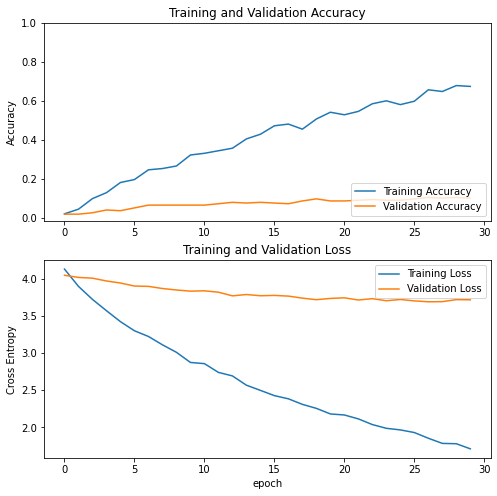

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  377


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
sequential_5 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
tf.nn.bias_add_4 (TFOpLambda (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv_9 (TFOpLambd (None, None, None, 3)     0         
_________________________________________________________________
efficientnet-b3 (Functional) (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0   

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_FineTune_dir,
                                                 save_weights_only=True)

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[cp_callback])

Epoch 30/60
115/115 [==============================] - 44s 205ms/step - loss: 1.5102 - accuracy: 0.7013 - val_loss: 3.8062 - val_accuracy: 0.1321
Epoch 31/60
115/115 [==============================] - 17s 146ms/step - loss: 1.2343 - accuracy: 0.6905 - val_loss: 3.9111 - val_accuracy: 0.1357
Epoch 32/60
115/115 [==============================] - 16s 136ms/step - loss: 1.1736 - accuracy: 0.7326 - val_loss: 4.0414 - val_accuracy: 0.1286
Epoch 33/60
115/115 [==============================] - 16s 135ms/step - loss: 1.0575 - accuracy: 0.7316 - val_loss: 4.0916 - val_accuracy: 0.1357
Epoch 34/60
115/115 [==============================] - 15s 133ms/step - loss: 0.9245 - accuracy: 0.7688 - val_loss: 4.0569 - val_accuracy: 0.1500
Epoch 35/60
115/115 [==============================] - 15s 129ms/step - loss: 0.8685 - accuracy: 0.7672 - val_loss: 4.1378 - val_accuracy: 0.1464
Epoch 36/60
115/115 [==============================] - 15s 129ms/step - loss: 0.8242 - accuracy: 0.7882 - val_loss: 4.2528 -

KeyboardInterrupt: ignored

After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
# import efficientnet.tfkeras
from tensorflow.keras.models import load_model

In [ ]:
model.save('/content/drive/MyDrive/Group/Flora/Private/Model/Flora_EfficientNetB3')

In [ ]:
model = load_model('/content/drive/MyDrive/Group/Flora/Private/Model/Flora_EfficientNetB3')

In [ ]:
!pip install nsvision

In [ ]:
from tensorflow.keras.models import load_model
import nsvision as nv
import numpy as np

image_path = '/content/download.jpg'
image = nv.imread(image_path, resize=(300, 300))
image = nv.expand_dims(image)
preds = model.predict(image.tolist())
preds = np.argmax(preds, axis=1)
preds = class_names[int(preds)]
preds